# Overview

Model-Based Temporal Abstraction involves simultaneuously learning
1) skill-conditioned low-level policy
2) skill-conditioned temporally abstract world model

Notation
- skill-conditioned low-level policy: $\pi_{\theta}(a_t|s_t, z)$
    - $\theta$ are parameters
    - $a_t \in A$ is current action selected by agent
    - $s_t \in S$ is current state
    - $z \in Z$ is abstract skill variable that encodes a skill

- skill-conditioned temporally abstract world model (TAWM): $p_{\psi}(s'|s,z)$ (models distribution of states agent is in after skill $z$)
    - $\psi$ parameters
    - $z$ is current skill

Note: low-level policy and TAWM not trained on rewards, reward function is provided later for planning with the learned skills 





In [1]:
# Import the necessary packages for the whole script
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Independent, TransformedDistribution
from torch.distributions.transforms import TanhTransform
import gymnasium as gym
import mujoco
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import minari
from torch.utils.data import Dataset, DataLoader
import wandb
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

### Learning $\pi_{\theta}$ and $p_{\psi}$

Learning $\pi_{\theta}$ and $p_{\psi}$ requires treating skills as latent variables and optimizing the ELBO

$$
\mathcal{L}(\theta,\psi,\phi,\omega)
= \mathbb{E}_{\tau_T \sim \mathcal{D}}\!\left[
  \mathbb{E}_{q_\phi(z\,|\,\tau_T)}\!\left[
    \log \pi_\theta(\bar{a}\,|\,\bar{s}, z)
    + \log p_\psi(s_T \,|\, s_0, z)
  \right]
  - D_{\mathrm{KL}}\!\left(q_\phi(z\,|\,\tau_T)\,\|\,p_\omega(z\,|\,s_0)\right)
\right].
$$

where $\tau_T$ is a T-length subtrajectory sampled from the offline dataset $\mathcal{D}$, $\bar{s}$ and $\bar{a}$ are state and action sequences of $\tau_T$, $q_{\psi}$ is a posterior over $z$ given $\tau_T$, and $p_{\omega}$ is a prior of $z$ given $s_0$.

The first term is the log-likelihood of demonstrator actions. This ensures that the low-level policy can reproduce a demonstrator's action sequence given a skill. This forces $z$ to encode control-relevant information.

The second term is the log-likelihood of long-term state transitions. This term ensures that we learn relationships between $z$ to what possible $s_T$ could result from. the skill.

Finally, the last term is the KL divergence between skill posterior and prior (encourages compression of skills). Therefore, maximizing this ELBO makes skills $z$ explain the data and keeps the KL divergence small. This ensures that the skill is start-state predictable.

In [2]:
# According to the paper, each layer contains 256 neurons
NUM_NEURONS = 256
# The dimension of the abstract skill variable, z
Z_DIM = 256

# Skill Posterior, q_phi
class SkillPosterior(nn.Module):
    """
    Input: sequence of skills and actions
    Output: mean and std over z

    1. Linear layer w/ ReLU activation for the state sequence
    2. Single-layer bidirectional GRU for embedded states and action sequence (concatenated)
    3. Extract mean and std of layer 2's output
    """
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(in_features=self.state_dim, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.bi_gru = nn.GRU(input_size=NUM_NEURONS+self.action_dim, hidden_size= NUM_NEURONS//2, bidirectional=True, batch_first=True)
        self.mean = MeanNetwork(Z_DIM)
        self.std = StandardDeviationNetwork(Z_DIM)

    def forward(self, state_sequence, action_sequence):
        embedded_states = self.relu(self.fc1(state_sequence))
        concatenated = torch.cat([embedded_states, action_sequence], dim=-1)
        x, _ = self.bi_gru(concatenated) # [B, T, NUM_NEURONS]
        seq_emb = x.mean(dim=1) # [B, NUM_NEURONS]
        mean = self.mean.forward(seq_emb)
        std = self.std.forward(seq_emb)
        return mean, std
        # can also use single directional gru and take final hidden state

# Low-Level Skill-Conditioned Policy, pi_theta
class SkillPolicy(nn.Module):
    """
    Input: Current state and a skill, z
    Output: mean and std over a

    1. 2-layer shared network w/ ReLU activations for the state and abstract skill (concatenated)
    2. Extract mean and std of layer 1's output
    """
    def __init__(self, state_dim, action_dim):
        super().__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(in_features=self.state_dim+Z_DIM, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.mean = MeanNetwork(self.action_dim)
        self.std = StandardDeviationNetwork(self.action_dim)
    
    def forward(self, state, z):
        c = torch.cat([state, z], dim=-1)
        x = self.relu(self.fc1(c))
        x = self.relu(self.fc2(x))
        mean = self.mean(x)
        std = self.std(x)
        return mean, std
        

# Temporally-Abstract World Model, p_psi
class TAWM(nn.Module):
    """
    Input: initial state, along with the abstract skill
    Output: mean and std over terminal state

    1. 2-layer shared network w/ ReLU activations for initial state and abstract skill (concatenated)
    2. Extract mean and std of layer 1's output
    """
    def __init__(self, state_dim):
        super().__init__()

        self.state_dim = state_dim
        self.fc1 = nn.Linear(in_features=self.state_dim+Z_DIM, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.mean = MeanNetwork(self.state_dim)
        self.std = StandardDeviationNetwork(self.state_dim)
    
    def forward(self, input_state, z):
        c = torch.cat([input_state, z], dim=-1)
        x = self.relu(self.fc1(c))
        x = self.relu(self.fc2(x))
        mean = self.mean(x)
        std = self.std(x)
        return mean, std

# Skill Prior, p_omega
class SkillPrior(nn.Module):
    """
    Input: Initial state, s0, in the trajectory
    Output: mean and std over the abstract skill, z

    1. 2-layer shared network w/ ReLU activations for the initial state
    2. Extract mean and std of layer 1's output
    """
    def __init__(self, state_dim):
        super().__init__()

        self.state_dim = state_dim
        self.fc1 = nn.Linear(in_features=self.state_dim, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.mean = MeanNetwork(Z_DIM)
        self.std = StandardDeviationNetwork(Z_DIM)
    
    def forward(self, input_state):
        x = self.relu(self.fc1(input_state))
        x = self.relu(self.fc2(x))
        mean = self.mean(x)
        std = self.std(x)
        return mean, std

class MeanNetwork(nn.Module):
    """
    Input: tensor to calculate mean
    Output: mean of input w/ dimension out_dim

    1. 2-layer network w/ ReLU activation for the first layer
    """
    def __init__(self, out_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=out_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        
        
class StandardDeviationNetwork(nn.Module):
    """
    Input: tensor to calculate std
    Output: std of input w/ dimension out_dim

    Note: the standard deviation is lower and upper bounded at 0.05 and 2.0
    - if std is 0, then log(std) -> inf
    - if std is large, then can affect training

    1. 2-layer linear network with ReLU activation after first layer and softplus after second

    """
    def __init__(self, out_dim, min_std=0.05, max_std=5.0):
        super().__init__()
        self.fc1 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, out_dim)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.min_std = min_std
        self.max_std = max_std
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        std = self.softplus(x) 
        #+ self.min_std  # lower bound
        #std = torch.clamp(std, max=self.max_std)
        return std


#### The Expectation-Maximization (EM) Algorithm

Since calculating the true posterior of $z$ given $\tau_T$ is intractable, we infer $q_{\psi}(z|\tau_T)$.

1. E-Step:
- Update $\psi$ w/gradient descent so that KL divergence between $q_\psi$ and true posterior is minimized

2. M-Step:
- Fixing $q_{\psi}$, update ($\theta, \psi, \omega$) s.t. ELBO is maximized using gradient ascent.


##### E-Step (Update $\psi$)

In this step, we want to minimize 

$$
\mathbb{E}_{\mathcal{T}_T\sim\mathcal{D}}
\Bigg[
\mathbb{E}_{z\sim q_\phi}
\bigg[
\log \frac{q_\phi\!\left(z\mid \bar{s},\bar{a}\right)}
{\pi_\theta\!\left(\bar{a}\mid \bar{s}, z\right)\,p_\omega\!\left(z\mid s_0\right)}
\bigg]
\Bigg]
$$

Equivalently, we want to minimize $\mathcal{KL}(q_{\psi}||p)$ where $p$, the true posterior is 

$$
p(z \mid \bar{s}, \bar{a}) = \frac{1}{\eta}\,\pi_\theta(\bar{a}\mid \bar{s}, z)\,p_\omega(z\mid s_0).
$$


##### M-Step (Update $\theta$, $\psi$, $\omega$)

In this step, we want to update $\theta$, $\psi$, and $\omega$ using gradient ascent to maximize the ELBO from above.

Both steps are trained using an Adam optimizer.


##### Dataset 1: AntMaze Medium

In [3]:
# Loads the AntMaze dataset in Minari format
ant_maze_dataset = minari.load_dataset('D4RL/antmaze/medium-play-v1')

In [4]:
print(ant_maze_dataset[0].actions.shape)
print(ant_maze_dataset[0].observations.keys())
print(ant_maze_dataset[0].observations["observation"].shape)
print(ant_maze_dataset[0].observations["achieved_goal"].shape)

(1000, 8)
dict_keys(['achieved_goal', 'desired_goal', 'observation'])
(1001, 27)
(1001, 2)


In [5]:
# B, the number of subtrajectories per batch (from paper)
B = 100

# T, the length of each subtrajectory (from paper)
T = 39

# AntMaze state and action dims (from Minari)
state_dim = 29
action_dim = 8

# Initialize the models
q_phi = SkillPosterior(state_dim=state_dim, action_dim=action_dim).to(device)
pi_theta = SkillPolicy(state_dim=state_dim, action_dim=action_dim).to(device)
p_psi = TAWM(state_dim=state_dim).to(device)
p_omega = SkillPrior(state_dim=state_dim).to(device)

In [6]:
class TrainingDataset(Dataset):
    """
    Input: LoadedMinari dataset and the length of the number of actions in each subtrajectory (T)
    Output: Dictionary with keys "s0, state_sequence, action_sequence, and sT"

    Finds all episodes that have at least T actions. Then, for each of those episodes, creates a sliding window to create subtrajectories w/ T actions
    """
    def __init__(self, ant_maze_dataset, T):
        self.T = T
        self.subtrajectories = []

        for ep in ant_maze_dataset.iterate_episodes():
            s = ep.observations["observation"]
            a = ep.actions
            l = len(s)
            if l < T + 1:
                continue
            
            stride = 3
            for t in range(0, l - T, stride):
                obs = ep.observations["observation"][t:t+T+1] # (27,)
                ach = ep.observations["achieved_goal"][t:t+T+1]  # (2,)
                state_sequence_extended = np.concatenate([obs, ach], axis=-1)
                state_sequence = state_sequence_extended[:-1]
                s0 = state_sequence[0]
                action_sequence = a[t: t + T]
                sT = state_sequence_extended[-1]
                self.subtrajectories.append((s0, state_sequence, action_sequence, sT))

    def __len__(self):
        return len(self.subtrajectories)

    def __getitem__(self, idx):
        s0, state_sequence, action_sequence, sT = self.subtrajectories[idx]

        return {
            "s0": torch.as_tensor(s0, dtype=torch.float32),
            "state_sequence": torch.as_tensor(state_sequence, dtype=torch.float32),
            "action_sequence": torch.as_tensor(action_sequence, dtype=torch.float32),
            "sT": torch.as_tensor(sT, dtype=torch.float32)
        }
    
def collate(batch):
    # Vertically stacks each of the components of the subtrajectories such that the first dimension is the batch
    return {
        "s0": torch.stack([b["s0"] for b in batch], 0),
        "state_sequence": torch.stack([b["state_sequence"] for b in batch], 0),
        "action_sequence": torch.stack([b["action_sequence"] for b in batch], 0),
        "sT": torch.stack([b["sT"] for b in batch], 0)
    }

# Create the dictionary of subtrajectories
dataset = TrainingDataset(ant_maze_dataset, T)

# Iterator w/ groups of subtrajectories from the dataset of size B 
loader = DataLoader(dataset, batch_size=B, shuffle=True, collate_fn=collate)

In [6]:

def make_episode_splits(minari_dataset, train=0.8, val=0.1, test=0.1, seed=0):
    """Return three lists of episode indices (train_ids, val_ids, test_ids)."""
    # Materialize all episodes once so we know how many there are
    episodes = list(minari_dataset.iterate_episodes())
    n = len(episodes)
    idxs = list(range(n))
    # Shuffle the indices
    random.Random(seed).shuffle(idxs)
    n_train = int(round(train * n))
    n_val = int(round(val * n))
    train_ids = idxs[:n_train]
    val_ids = idxs[n_train:n_train+n_val]
    test_ids = idxs[n_train+n_val:]
    return train_ids, val_ids, test_ids

class SubtrajDataset(Dataset):
    """
    Loops over minari_dataset.iterate_episodes(), but keeps only episodes whose index is in episode_ids
    """
    def __init__(self, minari_dataset, T, episode_ids, stride=3):
        self.T = T
        self.items = []  

        # Iterate all episodes but only process those whose global index is in episode_ids
        for ep_idx, ep in enumerate(minari_dataset.iterate_episodes()):
            if ep_idx not in set(episode_ids):
                continue
            obs = ep.observations["observation"]          
            ach = ep.observations["achieved_goal"]        
            act = ep.actions                               
            Ltot = len(obs)
            if Ltot < T + 1:
                continue

            state_ext = np.concatenate([obs, ach], axis=-1).astype(np.float32)
            for t in range(0, Ltot - T, stride):
                state_seq = state_ext[t:t+T]         
                s0 = state_seq[0]             
                action_seq = act[t:t+T].astype(np.float32)  
                sT = state_ext[t+T]           
                self.items.append((s0, state_seq, action_seq, sT))

    def __len__(self): 
        return len(self.items)

    def __getitem__(self, i):
        """standardize s0, state_sequence, and sT by (x - mean) / std"""
        
        s0, S, A, sT = self.items[i]
        if hasattr(self, "stats") and self.stats is not None:
            S_mean, S_std = self.stats
            S  = (S  - S_mean) / S_std
            s0 = (s0 - S_mean) / S_std
            sT = (sT - S_mean) / S_std
            A  = A
        return {
            "s0": torch.as_tensor(s0, dtype=torch.float32),
            "state_sequence": torch.as_tensor(S, dtype=torch.float32),
            "action_sequence": torch.as_tensor(A, dtype=torch.float32),
            "sT": torch.as_tensor(sT, dtype=torch.float32),
        }

def collate(batch):
    return {
        "s0": torch.stack([b["s0"] for b in batch], 0),
        "state_sequence": torch.stack([b["state_sequence"] for b in batch], 0),
        "action_sequence": torch.stack([b["action_sequence"] for b in batch], 0),
        "sT": torch.stack([b["sT"] for b in batch], 0),
    }


In [7]:
# Pick indices for train/test/split
train_ids, val_ids, test_ids = make_episode_splits(ant_maze_dataset, train=0.8, val=0.1, test=0.1, seed=0)
print(f"train:{len(train_ids)}  val:{len(val_ids)}  test:{len(test_ids)}")

# Datasets from episode subsets
train_ds = SubtrajDataset(ant_maze_dataset, T=T, episode_ids=train_ids, stride=3)
val_ds = SubtrajDataset(ant_maze_dataset, T=T, episode_ids=val_ids,   stride=3)
test_ds = SubtrajDataset(ant_maze_dataset, T=T, episode_ids=test_ids,  stride=3)  

print(f"train:{len(train_ds)}  val:{len(val_ds)}  test:{len(test_ds)}")

# find per-feature mean and std from all state_sequence timesteps in train_ds
def compute_stats(ds):
    Ss = []
    for item in ds.items:
        Ss.append(item[1])  # state_sequence [T,29]
    S = np.concatenate([x.reshape(-1, x.shape[-1]) for x in Ss], axis=0)
    S_mean, S_std = S.mean(0), S.std(0) + 1e-6
    return (S_mean, S_std)

S_mean, S_std = compute_stats(train_ds)

# pass stats into datasets
train_ds.stats = (S_mean, S_std)
val_ds.stats = (S_mean, S_std)

train_loader = DataLoader(train_ds, batch_size=B, shuffle=True,  collate_fn=collate, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=B, shuffle=False, collate_fn=collate, drop_last=False)


train:800  val:100  test:100
train:256800  val:32100  test:32100


In [8]:
test_ds.stats   = (S_mean, S_std)
test_loader = DataLoader(test_ds, batch_size=B, shuffle=False, collate_fn=collate, drop_last=False)

In [ ]:
eps = 1e-6

def policy_dist(mu, std):
    base = Independent(Normal(mu, std), 1)  
    return TransformedDistribution(base, [TanhTransform(cache_size=1)]) # This already squashes to -1, 1

def e_terms(batch):
    """Make the inferred skill posterior match the true posterior."""

    s0, S, A = batch["s0"], batch["state_sequence"], batch["action_sequence"]
    B, T, _ = S.shape

    mu_q, std_q = q_phi(S, A)
    z = mu_q + std_q * torch.randn_like(mu_q) # Get [B, z_dim]            

    # Extend the skill across time to get [B, T, z_dim]
    z_bt = z.unsqueeze(1).expand(B, T, -1)
    mu_pi, std_pi = pi_theta(S.reshape(B*T, -1), z_bt.reshape(B*T, -1)) # Get [B, T, action_dim]
    mu_pi, std_pi = mu_pi.view(B, T, -1), std_pi.view(B, T, -1)

    dist = policy_dist(mu_pi, std_pi)
    a_clp = A.clamp(-1 + eps, 1 - eps) # clamp actions to [-1, 1]
    log_pi_t = dist.log_prob(a_clp) # compute per-timestep log prob [B, T], summed over action dims
    log_pi = log_pi_t.sum(dim=1) # sum over time (subtrajectory)

    mu_pr, std_pr = p_omega(s0) # skill prior at start state
    log_p_omega = Independent(Normal(mu_pr, std_pr), 1).log_prob(z)   # [B]
    log_q = Independent(Normal(mu_q, std_q), 1).log_prob(z)     # [B]

    # L_E = - 1/B of the sum [ log low-level policy + log skill prior - log skill posterior ]
    L = -(log_pi + log_p_omega - log_q).mean()
    return {"e_loss": L, "act_ll_sum": log_pi.mean(), "prior_ll": log_p_omega.mean(), "post_ll": log_q.mean()}

def m_terms(batch):
    s0, S, A, sT = batch["s0"], batch["state_sequence"], batch["action_sequence"], batch["sT"]
    B, T, _ = S.shape

    mu_q, std_q = q_phi(S, A)
    z = mu_q + std_q * torch.randn_like(mu_q) # skill using posterior

    z_bt = z.unsqueeze(1).expand(B, T, -1)
    # Get the distribution over actions given the start states and skills
    mu_pi, std_pi = pi_theta(S.reshape(B*T, -1), z_bt.reshape(B*T, -1))
    mu_pi, std_pi = mu_pi.view(B, T, -1), std_pi.view(B, T, -1)

    dist = policy_dist(mu_pi, std_pi)
    a_clp = A.clamp(-1 + eps, 1 - eps)
    log_pi = dist.log_prob(a_clp).sum(dim=1)            

    # Get the distribution over terminal states using TAWM 
    mu_T, std_T = p_psi(s0, z)
    log_p_psi = Independent(Normal(mu_T, std_T), 1).log_prob(sT) # summed over state dims

    # Get the distribution over skill using start state
    mu_pr, std_pr = p_omega(s0)
    log_p_omega = Independent(Normal(mu_pr, std_pr), 1).log_prob(z)

    # L_M = - 1/B  of the sum [ log low-level policy + log TAWM + log skill prior ]
    L = -(log_pi + log_p_psi + log_p_omega).mean()
    return {"m_loss": L,
            "act_ll_sum": log_pi.mean(), "trans_ll": log_p_psi.mean(), "prior_ll": log_p_omega.mean()}



In [ ]:
@torch.no_grad()
def eval_epoch(val_loader, q_phi, pi_theta, p_psi, p_omega, device):
    """Compute validation E- and M-loss"""
    q_phi.eval()
    pi_theta.eval()
    p_psi.eval()
    p_omega.eval()
    e_sum, m_sum, n = 0.0, 0.0, 0
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        terms = e_terms(batch)
        e = terms["e_loss"]
        # e = compute_e_loss(batch)
        terms = m_terms(batch)
        m = terms["m_loss"]
        # m = compute_m_loss(batch)
        e_sum += float(e.item())
        m_sum += float(m.item())
        n += 1
    if n == 0: 
        return None, None
    return e_sum / n, m_sum / n

def skill_model_training_with_val(
    train_loader, val_loader,
    q_phi, pi_theta, p_psi, p_omega,
    e_lr=5e-5, m_lr=5e-5,
    epochs=50, e_steps=1, m_steps=1, grad_clip=1.0
):
    q_phi.to(device)
    pi_theta.to(device)
    p_psi.to(device)
    p_omega.to(device)

    e_opt = torch.optim.Adam(q_phi.parameters(), lr=e_lr)
    m_opt = torch.optim.Adam(list(pi_theta.parameters()) + list(p_psi.parameters()) + list(p_omega.parameters()), lr=m_lr)

    tr_e, tr_m, va_e, va_m = [], [], [], []

    for epoch in range(1, epochs+1):
        q_phi.train()
        pi_theta.train()
        p_psi.train()
        p_omega.train()
        e_run = m_run = 0.0 # Running e_loss, m_loss, in current epoch

        nb = 0

        for batch in train_loader:
            # Rebuilds dictionary but moves tensors to the device
            batch = {k: v.to(device) for k, v in batch.items()}
            nb += 1

            # E step: update q_phi
            # In E-step, train the posterior while freezing other parameters
            q_phi.train()
            pi_theta.eval()
            p_psi.eval()
            p_omega.eval()
            for p in q_phi.parameters(): 
                p.requires_grad_(True)
            for m in (pi_theta, p_psi, p_omega):
                for p in m.parameters(): 
                    p.requires_grad_(False)

            for _ in range(e_steps):
                e_opt.zero_grad(set_to_none=True)
                terms = e_terms(batch)
                e_loss = terms["e_loss"]
                e_loss.backward()
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(q_phi.parameters(), grad_clip)
                e_opt.step()
            e_run += float(e_loss.item())

            # M step: update theta, psi, omega
            # Freeze posterior weights, update all other weights

            q_phi.eval()
            pi_theta.train()
            p_psi.train()
            p_omega.train()
            for p in q_phi.parameters(): 
                p.requires_grad_(False)
            for m in (pi_theta, p_psi, p_omega):
                for p in m.parameters(): 
                    p.requires_grad_(True)

            for _ in range(m_steps):
                # Reset gradients
                m_opt.zero_grad(set_to_none=True)
                terms = m_terms(batch)
                m_loss = terms["m_loss"]
                m_loss.backward()
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(list(pi_theta.parameters()) + list(p_psi.parameters()) + list(p_omega.parameters()),grad_clip)
                m_opt.step()
            m_run += float(m_loss.item())

        # Calculate the average losses over all the batches in the epoch
        e_epoch = e_run / max(1, nb)
        m_epoch = m_run / max(1, nb)
        tr_e.append(e_epoch)
        tr_m.append(m_epoch)

        # validation
        ve, vm = eval_epoch(val_loader, q_phi, pi_theta, p_psi, p_omega, device)
        va_e.append(ve); va_m.append(vm)

        print(f"[Epoch {epoch:03d}/{epochs}] "
              f"train E:{e_epoch:.4f}  M:{m_epoch:.4f} "
              f"| val E:{ve:.4f}  M:{vm:.4f}")

        wandb.log({
            "train/E_loss": e_epoch,
            "train/M_loss": m_epoch,
            "val/E_loss": ve,
            "val/M_loss": vm,
            "epoch": epoch
        }, step=epoch)

    plt.figure(figsize=(7.5,4.5))
    plt.plot(tr_e, label="Train E-loss")
    plt.plot(tr_m, label="Train M-loss")
    if all(v is not None for v in va_e):
        plt.plot(va_e, label="Val E-loss")
    if all(v is not None for v in va_m):
        plt.plot(va_m, label="Val M-loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("EM training: train vs. val losses")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    fig = plt.gcf()
    wandb.log({"plots/loss_curves": wandb.Image(fig)}, step=epoch)
    plt.close(fig)

    return {"train_E": tr_e, "train_M": tr_m, "val_E": va_e, "val_M": va_m}


In [11]:
wandb.init(
    project="tawm-skill-learning",
    name="antmaze-medium_em",
    config=dict(
        B=B, T=T, Z_DIM=Z_DIM, NUM_NEURONS=NUM_NEURONS,
        e_lr=5e-5, m_lr=5e-5, e_steps=1, m_steps=1,
        dataset="D4RL/antmaze/medium-play-v1",
        device=device
    )
)

wandb.watch([q_phi, pi_theta, p_psi, p_omega], log="gradients", log_freq=200)

wandb: Currently logged in as: william-huang-08 (william-huang-08-yale-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[Epoch 001/100] train E:-6.4222  M:266.2190 | val E:-9.1184  M:262.8074
[Epoch 002/100] train E:-9.4775  M:262.1057 | val E:-9.3679  M:262.0602
[Epoch 003/100] train E:-9.6613  M:261.7758 | val E:-9.5016  M:262.4478
[Epoch 004/100] train E:-9.7767  M:261.3794 | val E:-9.5985  M:262.5307
[Epoch 005/100] train E:-9.8585  M:261.2081 | val E:-9.6766  M:261.9148
[Epoch 006/100] train E:-9.9243  M:260.9056 | val E:-9.7251  M:261.0118
[Epoch 007/100] train E:-9.9775  M:261.1617 | val E:-9.7790  M:262.3078
[Epoch 008/100] train E:-10.0225  M:260.9677 | val E:-9.8235  M:260.7084
[Epoch 009/100] train E:-10.0626  M:260.5400 | val E:-9.8551  M:261.2500
[Epoch 010/100] train E:-10.0961  M:260.5018 | val E:-9.8801  M:261.4217
[Epoch 011/100] train E:-10.1265  M:260.1407 | val E:-9.9052  M:261.3607
[Epoch 012/100] train E:-10.1518  M:260.2401 | val E:-9.9262  M:261.5512
[Epoch 013/100] train E:-10.1744  M:260.0667 | val E:-9.9489  M:261.6987
[Epoch 014/100] train E:-10.1961  M:260.0614 | val E:-9.96

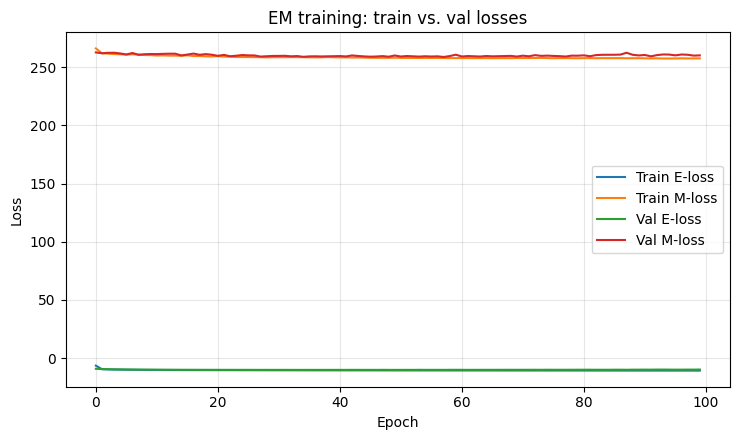

In [13]:
curves = skill_model_training_with_val(train_loader, val_loader, q_phi, pi_theta, p_psi, p_omega, epochs=100, e_lr=5e-5, m_lr=5e-5, e_steps=1, m_steps=1)


In [14]:
wandb.finish()


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train/E_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/M_loss,█▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/E_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▂▃▃▂▃▃
val/M_loss,█▇▆▅▇▆▃▅▄▃▂▃▁▂▂▃▂▂▁▂▂▃▂▁▂▂▂▂▂▃▁▃▃▂▄▄▅▇▅▃
epoch,100
train/E_loss,-10.69962
train/M_loss,257.67825
val/E_loss,-9.77663
val/M_loss,260.25778


In [15]:
# Load and save the model to a .pth file
def save_checkpoint(path, q_phi, pi_theta, p_psi, p_omega):
    ckpt = {
        "q_phi": q_phi.state_dict(),
        "pi_theta": pi_theta.state_dict(),
        "p_psi": p_psi.state_dict(),
        "p_omega": p_omega.state_dict(),
        "S_stats": {"mean": S_mean, "std": S_std},
        "config": dict(B=B, T=T, Z_DIM=Z_DIM, NUM_NEURONS=NUM_NEURONS,device=str(device))
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(ckpt, path)
    print(f"checkpoint saved -> {path}")

def load_checkpoint(path, q_phi, pi_theta, p_psi, p_omega, strict=True):
    ckpt = torch.load(path)
    q_phi.load_state_dict(ckpt["q_phi"], strict=strict)
    pi_theta.load_state_dict(ckpt["pi_theta"], strict=strict)
    p_psi.load_state_dict(ckpt["p_psi"], strict=strict)
    p_omega.load_state_dict(ckpt["p_omega"], strict=strict)
    stats = ckpt.get("S_stats", None)
    if stats is not None:
        global S_mean, S_std
        S_mean, S_std = stats["mean"], stats["std"]
    print(f"[checkpoint] loaded <- {path}")
    return ckpt

save_checkpoint("checkpoints/antmaze_em_unclamped_40_100.pth", q_phi, pi_theta, p_psi, p_omega)

# q_phi = SkillPosterior(state_dim=state_dim, action_dim=action_dim).to(device)
# pi_theta = SkillPolicy(state_dim=state_dim, action_dim=action_dim).to(device)
# p_psi = TAWM(state_dim=state_dim).to(device)
# p_omega = SkillPrior(state_dim=state_dim).to(device)

# _ = load_checkpoint("checkpoints/antmaze_em_clamped.pth", q_phi, pi_theta, p_psi, p_omega)
# q_phi.eval(); pi_theta.eval(); p_psi.eval(); p_omega.eval()




checkpoint saved -> checkpoints/antmaze_em_unclamped_40_100.pth


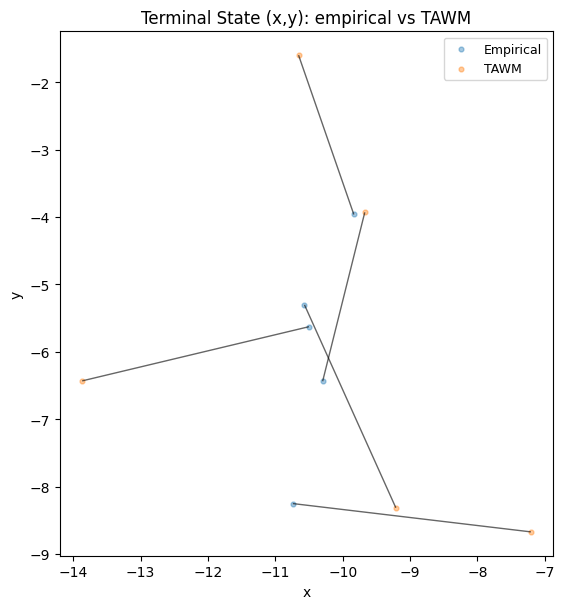

<Figure size 640x480 with 0 Axes>

In [111]:
def to_torch(x):
    return torch.as_tensor(x, dtype=torch.float32, device=device)

def policy_dist(mu, std):
    # build a tanh-squashed normal action dist
    base = Independent(Normal(mu, std.clamp_min(0.05)), 1) # clamps std to be at least 0.05 to prevent exploding/vanishing gradients
    return TransformedDistribution(base, [TanhTransform(cache_size=1)]) # Creates a Independent Normal over action dims applied Tanh Transform to map actions to (-1, 1)

def standardize_state(s): 
    return (s - S_mean) / S_std

def unstandardize_state(s):
    return s * S_std + S_mean

def pack_state_from_obs(obs):
    """
    Build 29-d state (observation + achieved goal).
    Take in env obs (which contains both "observation" and "achieved goal").
    """
    obs_vec = np.asarray(obs["observation"], dtype=np.float32).ravel()
    ag = np.asarray(obs.get("achieved_goal", obs_vec[:2]), dtype=np.float32).ravel()

    state = np.concatenate([obs_vec.astype(np.float32), ag.astype(np.float32)], 0) # Combines the 27-d and 2-d tensors
    return obs_vec.astype(np.float32), ag.astype(np.float32), state

def get_sim_handles(env):
    """Unwraps Gym wrappers to access MuJoCo model and data to work with qpos/qvel and forward dynamics. 
    Return (unwrapped MuJoCo environment, MuJoCo model, muJoCo data)"""
    t = env
    for attr in ["env", "unwrapped"]: # for the current env, replace env with env.env and then find env.env.unwrapped
        if hasattr(t, attr):
            t = getattr(t, attr)
    # t should now be the innermost env and grab the MuJoCo data and model
    # sim = getattr(t, "sim", None)
    # if sim is not None and hasattr(sim, "model") and hasattr(sim, "data"):
    #     return t, sim.model, sim.data
    
    # CHECK THIS
    if hasattr(t, "model") and hasattr(t, "data"):
        return t, t.model, t.data

def split_obs_to_qpos_qvel(s0_obs, s0_ag, env):
    """Split dataset obs into qpos and qvel to reset physics. Need to provide exact qpos and qvel to reset dataset state"""
    _, model, data = get_sim_handles(env)
    nq, nv = int(model.nq), int(model.nv)  # Ant: typically 15, 14

    s0_obs = np.asarray(s0_obs, np.float32).ravel()
    s0_ag  = np.asarray(s0_ag,  np.float32).ravel()

    qpos = data.qpos.ravel().copy()
    qvel = data.qvel.ravel().copy()

    # fill exact slices
    qpos[0:2] = s0_ag
    qpos[2:nq] = s0_obs[:(nq - 2)]
    qvel[:nv] = s0_obs[(nq - 2):(nq - 2 + nv)]

    return qpos.astype(np.float32), qvel.astype(np.float32)

def read_antmaze_obs(env):
    """Reconstruct AntMaze dict-observation from MuJoCo state."""
    t = env
    for attr in ("env", "unwrapped"):
        if hasattr(t, attr):
            t = getattr(t, attr)
    qpos = t.data.qpos.ravel()
    qvel = t.data.qvel.ravel()
    obs27 = np.concatenate([qpos[2:], qvel]).astype(np.float32)
    ag2 = qpos[:2].astype(np.float32)
    return {"observation": obs27, "achieved_goal": ag2}

def set_env_state(env, qpos, qvel):
    """Write qpos/qvel into MuJoCo and forward."""
    _, model, data = get_sim_handles(env)
    # Set the physical state
    data.qpos[:] = qpos
    data.qvel[:] = qvel
    # Required step after makeing a manual state change
    mujoco.mj_forward(model, data)

def recover_ant_env():
    return ant_maze_dataset.recover_environment()


def plot_pairs(emp_xy, taw_xy, title="", fixed_limits=(-10, 10, -10, 10)):
    """
    Draw segments from empirical to TAWM endpoints.
    """

    # Use all points
    E, P = emp_xy, taw_xy
    segs = np.stack([E, P], axis=1)  

    fig, ax = plt.subplots(figsize=(6.2, 6.2))
    ax.scatter(emp_xy[:, 0], emp_xy[:, 1], s=12, alpha=0.4, label="Empirical")
    ax.scatter(taw_xy[:, 0], taw_xy[:, 1], s=12, alpha=0.4, label="TAWM")
    ax.add_collection(LineCollection(segs, linewidths=1.0, colors="k", alpha=0.6))

    ax.set_aspect("equal", "box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend(loc="best", fontsize=9)

    # xmin, xmax, ymin, ymax = fixed_limits
    # ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    all_xy = np.vstack([emp_xy, taw_xy])
    pad = 0.05 * (all_xy.max(0) - all_xy.min(0) + 1e-9)
    ax.set_xlim(all_xy[:,0].min()-pad[0], all_xy[:,0].max()+pad[0])
    ax.set_ylim(all_xy[:,1].min()-pad[1], all_xy[:,1].max()+pad[1])
    plt.tight_layout(); plt.show()

    plt.tight_layout()
    plt.show()



@torch.no_grad()
def sample_skill_and_roll(env, s0_obs_ds, s0_ag_ds, N_rollouts=300, seed=0):
    """
    Reset to same physical s0 (qpos,qvel), then for each rollout:
      - read env dict-obs after reset
      - build s0 from that obs, sample z ~ p_omega(z|s0)
      - roll H steps with pi_theta under that z
    Also sample TAWM endpoints from p_psi(s_T|s0,z) for the SAME (s0,z).
    """
    H = 40

    # physical MuJoCo properties for the chosen start state
    s0_qpos, s0_qvel = split_obs_to_qpos_qvel(s0_obs_ds, s0_ag_ds, env)

    emp_xy, taw_xy = [], []

    p_omega.eval(); p_psi.eval(); pi_theta.eval()

    for _ in range(N_rollouts):
        # Refresh MuJoCo episode bookkeeping
        env.reset() 

        # Reset the start state
        set_env_state(env, s0_qpos, s0_qvel)

        # get the actual obs from the env of the start state
        obs = read_antmaze_obs(env)

        # get the combined state and standardize
        _, _, s0_env = pack_state_from_obs(obs)
        s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)

        # sample  a skill from from the skill prior at this s0
        mu_pr, std_pr = p_omega(s0_t)
        z = (mu_pr + std_pr * torch.randn_like(mu_pr)).squeeze(0) 

        # roll T steps with low-level policy (pi_theta(a|s, z)) with sampled skill
        pi_theta.eval()
        cur_obs = obs
        for t in range(H):
            # Build and standardize curr state
            _, _, st = pack_state_from_obs(cur_obs)
            st_t = to_torch(standardize_state(st)).unsqueeze(0)

            # Get the action distribution
            a_mu, a_std = pi_theta(st_t, z.unsqueeze(0))

            # Sample an action from the tanh-squashed normal
            a = policy_dist(a_mu, a_std).sample().squeeze(0).cpu().numpy().astype(np.float32)
            
            # Take a step with the action
            cur_obs, _, term, trunc, _ = env.step(a)
            if term or trunc:
                break

        # empirical terminal (x,y) from the last obs
        _, ag_emp, _ = pack_state_from_obs(cur_obs)
        emp_xy.append(ag_emp.copy())

        # Query world model p_psi(s_T | s0, z) to get mean and std 
        mu_T, std_T = p_psi(s0_t, z.unsqueeze(0)) 
        # Sample a terminal state and unstandardize
        sT_std = mu_T + (std_T) * torch.randn_like(mu_T)
        sT = unstandardize_state(sT_std.squeeze(0).cpu().numpy())
        
        taw_xy.append(sT[-2:].copy())

    return np.stack(emp_xy, 0), np.stack(taw_xy, 0)

env = recover_ant_env()

# find a dataset start 
for ep in ant_maze_dataset.iterate_episodes():
    if len(ep.observations["observation"]) >= T + 1:
        s0_obs_ds = ep.observations["observation"][0].astype(np.float32)   # 27-d
        s0_ag_ds  = ep.observations["achieved_goal"][0].astype(np.float32) # 2-d
        break

emp_xy, taw_xy = sample_skill_and_roll(env, s0_obs_ds, s0_ag_ds, N_rollouts=5, seed=42)

plot_pairs(emp_xy, taw_xy, title="Terminal State (x,y): empirical vs TAWM")



/var/folders/wp/q7yyy4ls2m3bvyscgh359t0r0000gn/T/ipykernel_32550/2998725534.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("viridis", len(trajs_xy))


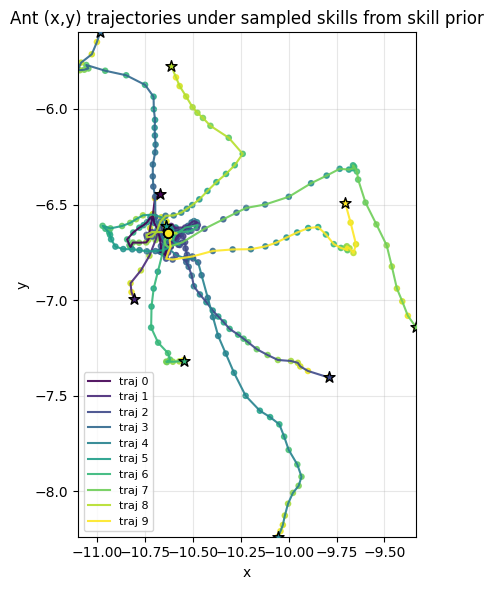

In [182]:
@torch.no_grad()
def sample_tawm_predictions(s0_env, z, N_samples=200):
    """Sample predicted terminal states from p_psi(s_T | s0, z)."""
    s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)
    mu_T, std_T = p_psi(s0_t, z.unsqueeze(0))  # [1, state_dim]
    dist = Independent(Normal(mu_T, std_T), 1)
    sT_samples_std = dist.sample((N_samples,)).squeeze(1).cpu().numpy()
    sT_samples = unstandardize_state(sT_samples_std)
    xy_samples = sT_samples[:, -2:]  # the achieved_goal part
    return xy_samples

def draw_cov_ellipse(ax, mean, cov, n_std=2.0, **kwargs):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellip = Ellipse(xy=mean, width=width, height=height, angle=theta, fill=False, **kwargs)
    ax.add_patch(ellip)
    
@torch.no_grad()
def rollout_xy_trajectories(env, s0_obs_ds, s0_ag_ds=None, N_trajs=3, horizon=T, seed=0,
    resample_skill_per_traj=True, # new z each traj if True, other wise same z for all traj
    use_prior=True, # if False, pass z explicitly
    z_fixed=None, # z to pass in
):
    """
    This function resets the env to the same physical start state (excluding xy), samples a skill z from the skill prior p_omega(z|s0).
    Then, it executes the low level policy pi_theta(a|s, z) for T steps
    Plots the path of the trajectory over the T steps for each trajectory.
    """
    H = horizon

    # Extract the qpos and qvel of the chosen start state
    s0_qpos, s0_qvel = split_obs_to_qpos_qvel(s0_obs_ds, s0_ag_ds, env)

    trajs_xy, zs_used = [], []

    # Precompute z if we want the same skill for all trajectories
    z_global = None
    if not resample_skill_per_traj:
        # Obtain env s0 (dict obs) once and sample z from prior at that exact s0
        env.reset()
        set_env_state(env, s0_qpos, s0_qvel)

        # Get the actual obs from the env of the start state
        obs = read_antmaze_obs(env)

        
        # Combine the obs and the xy location
        _, _, s0_env = pack_state_from_obs(obs)
        s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)

        # Use fixed if provided, otherwise just sample a skill
        if z_fixed is not None:
            z_global = z_fixed.to(device).detach().clone().squeeze(0)
        elif use_prior:
            mu_pr, std_pr = p_omega(s0_t)
            z_global = (mu_pr + std_pr * torch.randn_like(mu_pr)).squeeze(0)

    for k in range(N_trajs):
        env.reset()
        # Reset sim to the same physical start
        set_env_state(env, s0_qpos, s0_qvel)

        obs = read_antmaze_obs(env)

        _, ag0, s0_env = pack_state_from_obs(obs)
        s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)

        # Choose skill for this trajectory
        if resample_skill_per_traj:
            if z_fixed is not None:
                z = z_fixed.to(device).detach().clone().squeeze(0)
            elif use_prior:
                mu_pr, std_pr = p_omega(s0_t)
                z = (mu_pr + std_pr * torch.randn_like(mu_pr)).squeeze(0)
        else:
            z = z_global

        zs_used.append(z.detach().cpu())

        # Rollout and collect (x,y) at each step using pi_theta(a|s, z)
        xy = [ag0.copy()]
        pi_theta.eval()
        cur_obs = obs
        for t in range(H):
            _, _, st = pack_state_from_obs(cur_obs)
            st_t = to_torch(standardize_state(st)).unsqueeze(0)
            a_mu, a_std = pi_theta(st_t, z.unsqueeze(0))
            a = policy_dist(a_mu, a_std).sample().squeeze(0).cpu().numpy().astype(np.float32)
            cur_obs, _, term, trunc, _ = env.step(a)
            _, ag_t, _ = pack_state_from_obs(cur_obs)
            xy.append(ag_t.copy())
            if term or trunc:
                break

        trajs_xy.append(np.stack(xy, axis=0))

    return trajs_xy, zs_used


def plot_xy_trajectories(trajs_xy, title=""):
    """
    Plots each trajectory as a polyline with start plotted as circle, end as star
    """
    fig, ax = plt.subplots(figsize=(6.8, 6))

    # Choose colors for each trajectory
    colors = cm.get_cmap("viridis", len(trajs_xy))

    # Plot each of the trajectories 
    for i, xy in enumerate(trajs_xy):
        c = colors(i)# set the color for the trajectory
        ax.plot(xy[:,0], xy[:,1], '-', lw=1.5, alpha=0.9, color=c, label=f"traj {i}") # draw the path
        ax.scatter(xy[0,0],  xy[0,1],  s=40, marker='o', color=c, edgecolor='k', zorder=3) # draw the start
        ax.scatter(xy[-1,0], xy[-1,1], s=70, marker='*', color=c, edgecolor='k', zorder=3) # draw the end
        tcolors = np.linspace(0, 1, len(xy)) 
        ax.scatter(xy[:,0], xy[:,1], c=tcolors, cmap="viridis", s=14, alpha=0.8) # points along trajectory get brighter

    ax.set_aspect('equal', 'box')
    all_xy = np.concatenate(trajs_xy, axis=0)
    lo = all_xy.min(axis=0)
    hi = all_xy.max(axis=0)
    ax.set_xlim(lo[0], hi[0])
    ax.set_ylim(lo[1], hi[1])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

trajs_xy, zs_used = rollout_xy_trajectories(env, s0_obs_ds, s0_ag_ds,
    N_trajs=10,    
    horizon=30, # same T trained p_psi on
    seed=123,
    resample_skill_per_traj=False, 
    use_prior=True                 
)

plot_xy_trajectories(trajs_xy, title="Ant (x,y) trajectories under sampled skills from skill prior")


/var/folders/wp/q7yyy4ls2m3bvyscgh359t0r0000gn/T/ipykernel_32550/1952567934.py:150: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("viridis", len(trajs_xy))


NameError: name 'Ellipse' is not defined

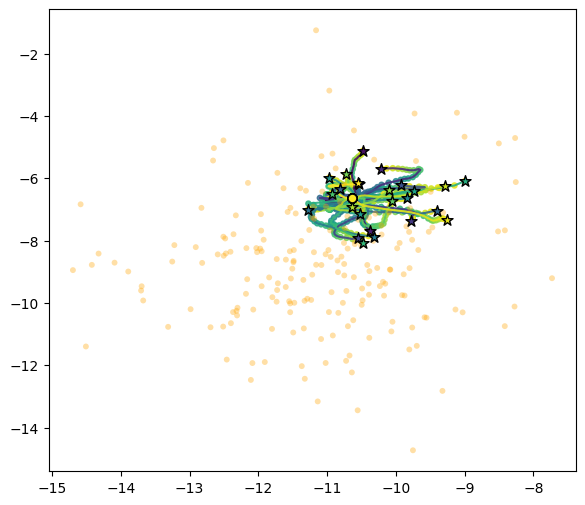

In [ ]:
@torch.no_grad()
def sample_tawm_predictions(s0_env, z, N_samples=200):
    """Sample predicted terminal states from p_psi(s_T | s0, z)."""
    s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)
    mu_T, std_T = p_psi(s0_t, z.unsqueeze(0))  # [1, state_dim]
    dist = Independent(Normal(mu_T, std_T), 1)
    sT_samples_std = dist.sample((N_samples,)).squeeze(1).cpu().numpy()
    sT_samples = unstandardize_state(sT_samples_std)
    xy_samples = sT_samples[:, -2:]  # the achieved_goal part
    return xy_samples

def draw_cov_ellipse(ax, mean, cov, n_std=2.0, **kwargs):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellip = Ellipse(xy=mean, width=width, height=height, angle=theta, fill=False, **kwargs)
    ax.add_patch(ellip)

@torch.no_grad()
def rollout_xy_trajectories(env, s0_obs_ds, s0_ag_ds=None, N_trajs=3, horizon=T, seed=0,
    resample_skill_per_traj=True, # new z each traj if True, other wise same z for all traj
    use_prior=True, # if False, pass z explicitly
    z_fixed=None, # z to pass in
):
    """
    This function resets the env to the same physical start state (excluding xy), samples a skill z from the skill prior p_omega(z|s0).
    Then, it executes the low level policy pi_theta(a|s, z) for T steps
    Plots the path of the trajectory over the T steps for each trajectory.
    """
    H = horizon

    # Extract the qpos and qvel of the chosen start state
    s0_qpos, s0_qvel = split_obs_to_qpos_qvel(s0_obs_ds, s0_ag_ds, env)

    trajs_xy, zs_used = [], []

    # Precompute z if we want the same skill for all trajectories
    z_global = None
    if not resample_skill_per_traj:
        # Obtain env s0 (dict obs) once and sample z from prior at that exact s0
        env.reset()
        set_env_state(env, s0_qpos, s0_qvel)

        # Get the actual obs from the env of the start state
        zero_act = np.zeros((env.action_space.shape[0],), dtype=np.float32)
        obs, _, _, _, _ = env.step(zero_act)
        
        # Combine the obs and the xy location
        _, _, s0_env = pack_state_from_obs(obs)
        s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)

        # Use fixed if provided, otherwise just sample a skill
        if z_fixed is not None:
            z_global = z_fixed.to(device).detach().clone().squeeze(0)
        elif use_prior:
            mu_pr, std_pr = p_omega(s0_t)
            z_global = (mu_pr + std_pr * torch.randn_like(mu_pr)).squeeze(0)

    for k in range(N_trajs):
        env.reset()
        # Reset sim to the same physical start
        set_env_state(env, s0_qpos, s0_qvel)

        zero_act = np.zeros((env.action_space.shape[0],), dtype=np.float32)
        obs, _, _, _, _ = env.step(zero_act)

        _, ag0, s0_env = pack_state_from_obs(obs)
        s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)

        # Choose skill for this trajectory
        if resample_skill_per_traj:
            if z_fixed is not None:
                z = z_fixed.to(device).detach().clone().squeeze(0)
            elif use_prior:
                mu_pr, std_pr = p_omega(s0_t)
                z = (mu_pr + std_pr * torch.randn_like(mu_pr)).squeeze(0)
        else:
            z = z_global

        zs_used.append(z.detach().cpu())

        # Rollout and collect (x,y) at each step using pi_theta(a|s, z)
        xy = [ag0.copy()]
        pi_theta.eval()
        cur_obs = obs
        for t in range(H):
            _, _, st = pack_state_from_obs(cur_obs)
            st_t = to_torch(standardize_state(st)).unsqueeze(0)
            a_mu, a_std = pi_theta(st_t, z.unsqueeze(0))
            a = policy_dist(a_mu, a_std).sample().squeeze(0).cpu().numpy().astype(np.float32)
            cur_obs, _, term, trunc, _ = env.step(a)
            _, ag_t, _ = pack_state_from_obs(cur_obs)
            xy.append(ag_t.copy())
            if term or trunc:
                break

        trajs_xy.append(np.stack(xy, axis=0))

    return trajs_xy, zs_used, s0_env


# def plot_xy_trajectories(trajs_xy, title="", xy_samples = None):
#     """
#     Plots each trajectory as a polyline with start plotted as circle, end as star
#     """
#     fig, ax = plt.subplots(figsize=(6.8, 6))

#     # Choose colors for each trajectory
#     colors = cm.get_cmap("viridis", len(trajs_xy))

#     # Plot each of the trajectories 
#     for i, xy in enumerate(trajs_xy):
#         c = colors(i)# set the color for the trajectory
#         ax.plot(xy[:,0], xy[:,1], '-', lw=1.5, alpha=0.9, color=c, label=f"traj {i}") # draw the path
#         ax.scatter(xy[0,0],  xy[0,1],  s=40, marker='o', color=c, edgecolor='k', zorder=3) # draw the start
#         ax.scatter(xy[-1,0], xy[-1,1], s=70, marker='*', color=c, edgecolor='k', zorder=3) # draw the end
#         tcolors = np.linspace(0, 1, len(xy)) 
#         ax.scatter(xy[:,0], xy[:,1], c=tcolors, cmap="viridis", s=14, alpha=0.8) # points along trajectory get brighter
#     if xy_samples is not None:
#         ax.scatter(
#             xy_samples[:, 0],
#             xy_samples[:, 1],
#             c='orange',
#             s=15,
#             alpha=0.25,
#             label="TAWM samples"
#         )
#         # Optionally draw covariance ellipse
#         cov = np.cov(xy_samples.T)
#         mean = xy_samples.mean(axis=0)
#         draw_cov_ellipse(ax, mean, cov, edgecolor='darkorange', lw=2, alpha=0.7)
        
#     ax.set_aspect('equal', 'box')
#     all_xy = np.concatenate(trajs_xy, axis=0)
#     lo = all_xy.min(axis=0)
#     hi = all_xy.max(axis=0)
#     ax.set_xlim(lo[0], hi[0])
#     ax.set_ylim(lo[1], hi[1])
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_title(title)
#     ax.grid(True, alpha=0.3)
#     # ax.legend(loc="best", fontsize=8)
#     plt.tight_layout()
#     plt.show()
def plot_xy_trajectories(trajs_xy, title="", xy_samples=None):
    fig, ax = plt.subplots(figsize=(6.8, 6))
    colors = cm.get_cmap("viridis", len(trajs_xy))

    for i, xy in enumerate(trajs_xy):
        c = colors(i)
        ax.plot(xy[:,0], xy[:,1], '-', lw=1.5, alpha=0.9, color=c)
        ax.scatter(xy[0,0], xy[0,1], s=40, marker='o', color=c, edgecolor='k', zorder=3)
        ax.scatter(xy[-1,0], xy[-1,1], s=70, marker='*', color=c, edgecolor='k', zorder=3)
        tcolors = np.linspace(0, 1, len(xy))
        ax.scatter(xy[:,0], xy[:,1], c=tcolors, cmap="viridis", s=14, alpha=0.8)

    if xy_samples is not None:
        ax.scatter(
            xy_samples[:, 0], xy_samples[:, 1],
            s=18, alpha=0.35, c='orange', edgecolors='none', zorder=2, label="TAWM samples"
        )
        cov = np.cov(xy_samples.T)
        mean = xy_samples.mean(axis=0)
        draw_cov_ellipse(ax, mean, cov, edgecolor='darkorange', lw=2, alpha=0.9)

    # ----- bounds: include samples if provided -----
    all_xy = np.concatenate(trajs_xy, axis=0)
    if xy_samples is not None:
        all_xy = np.vstack([all_xy, xy_samples])
    lo, hi = all_xy.min(axis=0), all_xy.max(axis=0)
    pad = 0.05 * (hi - lo + 1e-9)
    ax.set_xlim(lo[0]-pad[0], hi[0]+pad[0])
    ax.set_ylim(lo[1]-pad[1], hi[1]+pad[1])

    ax.set_aspect('equal', 'box')
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    plt.tight_layout(); plt.show()


trajs_xy, zs_used, s0_env = rollout_xy_trajectories(env, s0_obs_ds, s0_ag_ds,
    N_trajs=25,    
    horizon=30, # same T trained p_psi on
    seed=123,
    resample_skill_per_traj=False, 
    use_prior=True                 
)

xy_pred_samples = sample_tawm_predictions(s0_env, zs_used[0], N_samples=200)

plot_xy_trajectories(trajs_xy, title="Ant (x,y) trajectories under sampled skills from skill prior", xy_samples=xy_pred_samples)


/var/folders/wp/q7yyy4ls2m3bvyscgh359t0r0000gn/T/ipykernel_32550/3911462669.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("viridis", len(trajs_xy))


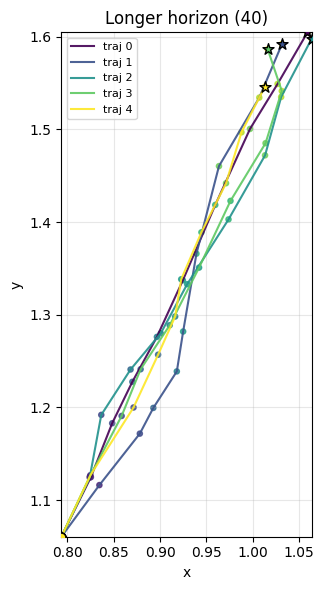

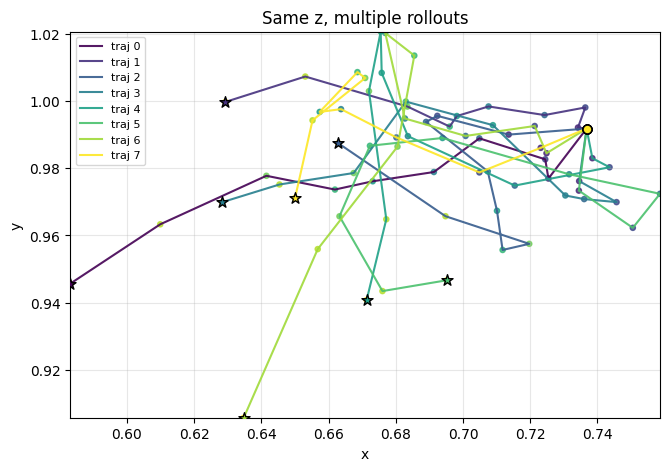

In [109]:
# resample skill every rollout
trajs_xy_long, _ = rollout_xy_trajectories(env, s0_obs_ds, s0_ag_ds,
                                           N_trajs=5, horizon=9,
                                           resample_skill_per_traj=True, use_prior=True)
plot_xy_trajectories(trajs_xy_long, title="Longer horizon (40)")

# fixed-skill repeatability (should cluster)
trajs_xy_fixed, _ = rollout_xy_trajectories(env, s0_obs_ds, s0_ag_ds,
                                            N_trajs=8, horizon=9,
                                            resample_skill_per_traj=False, use_prior=True)
plot_xy_trajectories(trajs_xy_fixed, title="Same z, multiple rollouts")



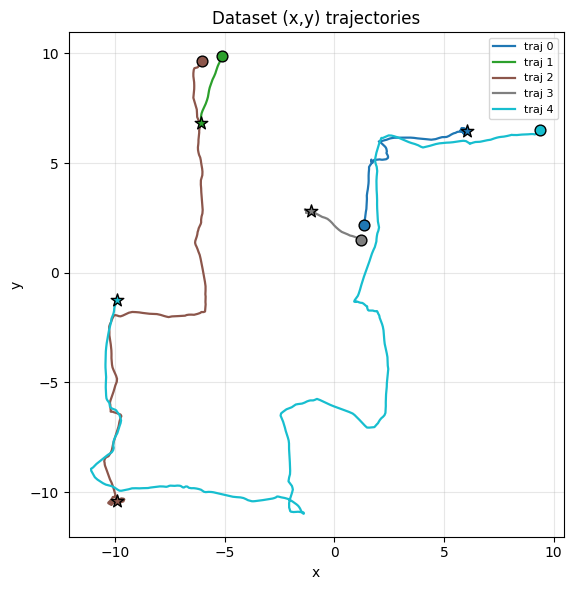

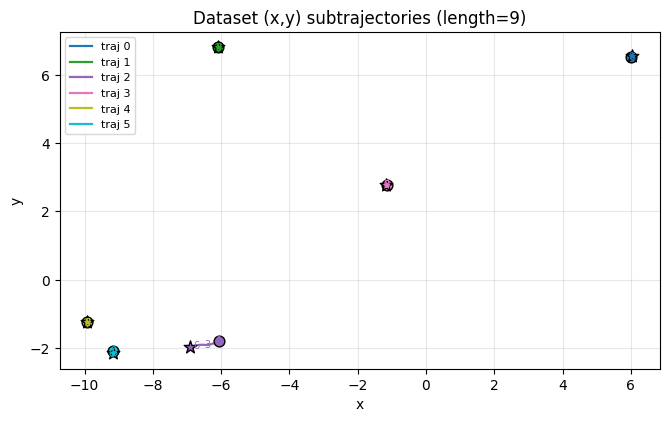

In [73]:
# %% View (x,y) trajectories directly from the dataset (no rollouts)
import numpy as np
import matplotlib.pyplot as plt
import random

def ep_xy_from_minari_episode(ep):
    """
    Extract (x,y) across time from a Minari AntMaze episode.
    Prefers 'achieved_goal' (2-d); falls back to first 2 dims of qpos if needed.
    Returns: xy  [L, 2]
    """
    if "achieved_goal" in ep.observations:
        xy = np.asarray(ep.observations["achieved_goal"], dtype=np.float32)
    else:
        obs = np.asarray(ep.observations["observation"], dtype=np.float32)  # (L, 27) for AntMaze
        # if the dataset didn't include achieved_goal, the first two entries of qpos are (x,y)
        xy = obs[:, :2]
    return xy

def sample_subtraj(xy, length, rng):
    """Return a contiguous sub-trajectory of given length from xy [L,2]."""
    L = len(xy)
    if length is None or length >= L:
        return xy
    if L < length:
        return None
    start = rng.randint(0, L - length + 1)
    return xy[start:start+length]

def plot_dataset_trajectories(
    dataset,
    n_trajs=5,
    length=None,          # None = plot full episodes; int = plot subtraj length (e.g., T)
    seed=0,
    stride_markers=1,     # label every k steps
    title=None
):
    """
    Randomly pick episodes from `dataset` and plot their (x,y) paths.
    - n_trajs: how many trajectories to draw
    - length: None for full episode, or an int for fixed-length subtrajectories
    """
    rng = np.random.RandomState(seed)

    # collect candidate episodes (filter by length if needed)
    episodes = list(dataset.iterate_episodes())
    if length is not None:
        episodes = [ep for ep in episodes if len(ep.observations["observation"]) >= length]
        if not episodes:
            raise RuntimeError(f"No episodes with at least {length} steps.")

    # sample episodes without replacement if possible
    picks = rng.choice(len(episodes), size=min(n_trajs, len(episodes)), replace=False)

    # build trajectories
    trajs = []
    for idx in picks:
        ep = episodes[idx]
        xy = ep_xy_from_minari_episode(ep)   # [L,2]
        xy_sub = sample_subtraj(xy, length, rng)
        if xy_sub is None: 
            continue
        trajs.append(xy_sub)

    if not trajs:
        raise RuntimeError("No trajectories selected to plot.")

    # --- plotting ---
    fig, ax = plt.subplots(figsize=(6.8, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(trajs)))

    all_xy = np.concatenate(trajs, axis=0)
    pad = 0.05 * (all_xy.max(0) - all_xy.min(0) + 1e-9)

    for i, (xy, c) in enumerate(zip(trajs, colors)):
        ax.plot(xy[:,0], xy[:,1], '-', lw=1.6, color=c, label=f"traj {i}")
        # start/end markers
        ax.scatter(xy[0,0],  xy[0,1],  s=60, marker='o', color=c, edgecolor='k', zorder=3)
        ax.scatter(xy[-1,0], xy[-1,1], s=90, marker='*', color=c, edgecolor='k', zorder=3)
        # optional sparse step labels
        if stride_markers and stride_markers > 0:
            for t in range(0, len(xy), stride_markers):
                ax.text(xy[t,0], xy[t,1], str(t), fontsize=7, ha='center', va='center', color=c)

    ax.set_aspect('equal', 'box')
    ax.set_xlim(all_xy[:,0].min()-pad[0], all_xy[:,0].max()+pad[0])
    ax.set_ylim(all_xy[:,1].min()-pad[1], all_xy[:,1].max()+pad[1])
    ax.set_xlabel("x"); ax.set_ylabel("y")
    if title is None:
        title = "Dataset (x,y) trajectories" if length is None else f"Dataset (x,y) subtrajectories (length={length})"
    ax.set_title(title)
    ax.grid(True, alpha=0.3); ax.legend(fontsize=8)
    plt.tight_layout(); plt.show()

# ---- usage examples ----
# A) Plot 5 full-episode trajectories
plot_dataset_trajectories(ant_maze_dataset, n_trajs=5, length=None, seed=123, stride_markers=0)

# B) Plot 6 random subtrajectories of length T (matches your train window)
plot_dataset_trajectories(ant_maze_dataset, n_trajs=6, length=T, seed=123, stride_markers=3)


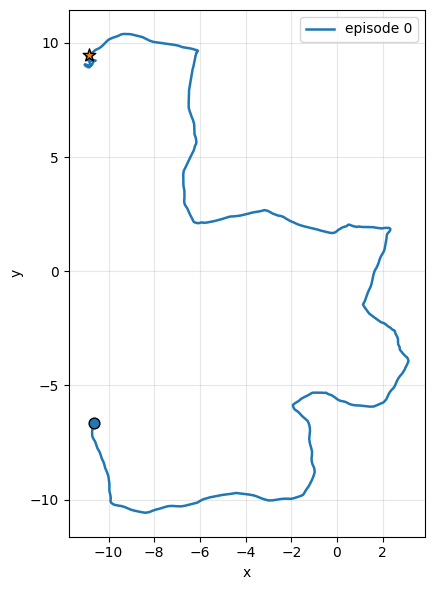

In [74]:
def plot_episode_xy(dataset, ep_idx, stride_labels=0):
    ep = list(dataset.iterate_episodes())[ep_idx]
    xy = np.asarray(ep.observations["achieved_goal"], np.float32)  # [L,2]
    fig, ax = plt.subplots(figsize=(6.2,6))
    ax.plot(xy[:,0], xy[:,1], '-', lw=1.8, label=f"episode {ep_idx}")
    ax.scatter(xy[0,0], xy[0,1], s=60, marker='o', edgecolor='k', zorder=3)
    ax.scatter(xy[-1,0], xy[-1,1], s=90, marker='*', edgecolor='k', zorder=3)
    if stride_labels:
        for t in range(0, len(xy), stride_labels):
            ax.text(xy[t,0], xy[t,1], str(t), fontsize=7, ha='center', va='center')
    ax.set_aspect('equal', 'box'); ax.grid(True, alpha=0.3)
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.legend(); plt.tight_layout(); plt.show()

# usage
plot_episode_xy(ant_maze_dataset, ep_idx=0, stride_labels=0)


In [87]:
# cem_planner.py
# ------------------------------------------------------------
# Cross-Entropy Method (CEM) planner for your skill models.
# Expects the following globals to be defined by your training
# script before importing/using this module:
#   device:    torch.device
#   Z_DIM:     int (e.g., 256)
#   T:         int horizon per skill (your training window length)
#   S_mean, S_std: np arrays of shape [state_dim] from train stats
#   p_omega:   SkillPrior(s) -> (mu_z, std_z)   [B, Z_DIM]
#   p_psi:     TAWM(s, z)    -> (mu_sT, std_sT) [B, state_dim]
#   pi_theta:  SkillPolicy(s, z) -> (mu_a, std_a)  (tanh-squashed at call)
#
# This file also includes robust helpers to set/reset Mujoco state.
# ------------------------------------------------------------

import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal, Independent, TransformedDistribution
from torch.distributions.transforms import TanhTransform

# ---------- tiny shims (use yours if already defined) ----------
def policy_dist(mu: torch.Tensor, std: torch.Tensor):
    """Tanh-squashed Gaussian for [-1,1] actions."""
    std = std.clamp_min(0.05).clamp_max(5.0)
    base = Independent(Normal(mu, std), 1)
    return TransformedDistribution(base, [TanhTransform(cache_size=1)])

def get_sim_handles(env):
    """Return (base_env, model, data), unwrapping common wrappers."""
    t = env
    for attr in ["env", "unwrapped"]:
        if hasattr(t, attr):
            t = getattr(t, attr)
    sim = getattr(t, "sim", None)
    if sim is not None and hasattr(sim, "model") and hasattr(sim, "data"):
        return t, sim.model, sim.data
    if hasattr(t, "model") and hasattr(t, "data"):
        return t, t.model, t.data
    raise RuntimeError("Could not access MuJoCo model/data.")

def split_obs_to_qpos_qvel(s0_obs, env):
    """Split flat dataset obs into env-sized (qpos,qvel), padding/truncating if needed."""
    _, model, _ = get_sim_handles(env)
    nq, nv = int(model.nq), int(model.nv)
    s0_obs = np.asarray(s0_obs, dtype=np.float32).ravel()
    qpos_raw = s0_obs[:nq]
    qvel_raw = s0_obs[nq:nq+nv]
    qpos = np.zeros(nq, dtype=np.float32); qpos[:min(nq, qpos_raw.size)] = qpos_raw[:min(nq, qpos_raw.size)]
    qvel = np.zeros(nv, dtype=np.float32);  qvel[:min(nv, qvel_raw.size)] = qvel_raw[:min(nv, qvel_raw.size)]
    return qpos, qvel

def set_env_state(env, qpos, qvel):
    """Write qpos/qvel into MuJoCo and forward."""
    base, model, data = get_sim_handles(env)
    if data.qpos.size != qpos.size or data.qvel.size != qvel.size:
        raise RuntimeError(f"Size mismatch: qpos {qpos.size} vs {data.qpos.size}, qvel {qvel.size} vs {data.qvel.size}")
    data.qpos[:] = qpos; data.qvel[:] = qvel
    import mujoco
    mujoco.mj_forward(model, data)

def pack_state_from_obs(obs, ag_override=None):
    """
    Return obs_vec(27), ag(2), state(29) = [obs_vec, ag].
    Works for dict-obs (AntMaze) or flat arrays.
    """
    if isinstance(obs, dict):
        obs_vec = np.asarray(obs["observation"], np.float32).ravel()
        ag = np.asarray(obs.get("achieved_goal", obs_vec[:2]), np.float32).ravel()
    else:
        obs_vec = np.asarray(obs, np.float32).ravel()
        ag = np.asarray(ag_override if ag_override is not None else obs_vec[:2], np.float32).ravel()

    if obs_vec.size < 27: obs_vec = np.pad(obs_vec, (0, 27-obs_vec.size)).astype(np.float32)
    else:                  obs_vec = obs_vec[:27].astype(np.float32)
    if ag.size < 2:        ag = np.pad(ag, (0, 2-ag.size)).astype(np.float32)
    else:                  ag = ag[:2].astype(np.float32)

    state = np.concatenate([obs_vec, ag], axis=0).astype(np.float32)  # [29]
    return obs_vec, ag, state


# ---------- torch-native standardization ----------
# These globals must already exist in your training script:
#   device, S_mean, S_std
S_mean_t = torch.as_tensor(globals()["S_mean"], dtype=torch.float32, device=globals()["device"])
S_std_t  = torch.as_tensor(globals()["S_std"],  dtype=torch.float32, device=globals()["device"])
device   = globals()["device"]
Z_DIM    = int(globals()["Z_DIM"])
T        = int(globals()["T"])

def standardize_state_t(s_t: torch.Tensor) -> torch.Tensor:
    # s_t: [..., state_dim] torch tensor on device
    return (s_t - S_mean_t) / S_std_t

def unstandardize_state_t(s_t: torch.Tensor) -> torch.Tensor:
    return s_t * S_std_t + S_mean_t


# ---------------- CEM core ----------------
@torch.no_grad()
def cem_optimize(
    cost_fn,                    # (eps_seq [L,Z]) -> tensor [N] costs
    L, Z,                       # sequence length, z-dim
    iters=8,                    # CEM iterations
    popsize=512,                # population per iter
    elite_frac=0.1,             # top fraction kept
    init_std=1.0,               # initial std in epsilon space
    init_mean=None,             # optional mean in epsilon space
    seed=0
):
    rng = np.random.RandomState(seed)
    elites = max(1, min(popsize, int(round(elite_frac * popsize))))

    mean = torch.zeros(L, Z, device=device) if init_mean is None else init_mean.to(device)
    std  = torch.full((L, Z), float(init_std), device=device)

    for _ in range(iters):
        eps = torch.normal(mean.expand(popsize, -1, -1), std.expand(popsize, -1, -1))  # [N,L,Z]
        costs = cost_fn(eps)                    # [N]
        topk = torch.topk(-costs, k=elites).indices
        elite = eps[topk]                       # [E,L,Z]
        mean  = elite.mean(0)
        std   = elite.std(0).clamp_min(1e-3)
    return mean, std


# -------- z parameterization: epsilon -> z via prior --------
@torch.no_grad()
def eps_to_z_seq(eps_seq: torch.Tensor, s0_state_std: torch.Tensor):
    """
    eps_seq:       [L, Z_DIM] (torch)
    s0_state_std:  [state_dim] (torch, standardized)
    Returns z_seq: [L, Z_DIM]; propagate s_i via p_psi mean (no time dim).
    """
    p_omega = globals()["p_omega"]
    p_psi   = globals()["p_psi"]

    s_i = s0_state_std.clone()                # [state_dim]
    z_list = []
    for i in range(eps_seq.shape[0]):
        mu, sig = p_omega(s_i.unsqueeze(0))                   # [1, Z]
        z_i = (mu + sig * eps_seq[i:i+1, :]).squeeze(0)       # [Z]
        z_list.append(z_i)

        mu_T, _ = p_psi(s_i.unsqueeze(0), z_i.unsqueeze(0))   # [1, state_dim]
        s_i = mu_T.squeeze(0)                                 # standardized
    return torch.stack(z_list, dim=0)                          # [L, Z]


# ---------------- cost models ----------------
@torch.no_grad()
def rollout_terminal_prediction(s0_state_std: torch.Tensor, z_seq: torch.Tensor, length: int, var_pen=0.0):
    """
    Predict terminal state after 'length' skills by chaining p_psi means;
    also returns a crude variance penalty by averaging predicted stds.
    """
    p_psi = globals()["p_psi"]
    s_i = s0_state_std.clone()      # [state_dim]
    var_cost = 0.0
    for i in range(length):
        mu_T, std_T = p_psi(s_i.unsqueeze(0), z_seq[i].unsqueeze(0))  # [1, Sd], [1, Sd]
        s_i = mu_T.squeeze(0)
        if var_pen:
            var_cost += float(var_pen) * std_T.mean().item()
    return s_i, var_cost  # standardized


@torch.no_grad()
def make_goal_cost(goal_xy, length_pen=0.0, var_pen=0.0):
    """
    Returns a vectorized cost_fn for CEM over epsilon sequences.
    goal_xy: array-like (2,)
    """
    gx, gy = float(goal_xy[0]), float(goal_xy[1])

    def cost_fn(eps_batch):  # [N,L,Z]
        N, L, _ = eps_batch.shape
        costs = torch.empty(N, device=device, dtype=torch.float32)
        s0_std = cost_fn.s0_std                          # [state_dim], torch
        for n in range(N):
            z_seq = eps_to_z_seq(eps_batch[n], s0_std)   # [L, Z]
            sT_std, vpen = rollout_terminal_prediction(s0_std, z_seq, L, var_pen=var_pen)
            sT = unstandardize_state_t(sT_std)           # torch
            x, y = sT[-2:].tolist()
            d2 = (x - gx)**2 + (y - gy)**2
            costs[n] = d2 + length_pen * L + vpen
        return costs

    cost_fn.s0_std = None
    return cost_fn


# --------------- planning API ----------------
@torch.no_grad()
def plan_skill_sequence(
    env, s0_obs, goal_xy,
    L=5, iters=8, popsize=512, elite_frac=0.1, init_std=1.0,
    length_pen=0.0, var_pen=0.0, seed=0
):
    """
    Returns (z_seq [L,Z], pred_terminal_xy np.array(2,)).
    """
    # Build s0 for networks from env obs
    _, _, s0_full = pack_state_from_obs(s0_obs)           # numpy [state_dim]
    s0_std = torch.as_tensor(s0_full, dtype=torch.float32, device=device)
    s0_std = standardize_state_t(s0_std)                  # torch [state_dim]

    # bind cost function to this s0
    cost_fn = make_goal_cost(goal_xy, length_pen=length_pen, var_pen=var_pen)
    cost_fn.s0_std = s0_std

    # CEM in epsilon space (transformed via prior to z each step)
    mean_eps, _ = cem_optimize(
        cost_fn=cost_fn,
        L=L, Z=Z_DIM,
        iters=iters, popsize=popsize, elite_frac=elite_frac,
        init_std=init_std, seed=seed
    )
    # Convert best eps mean to a concrete z sequence (using current s0)
    z_seq = eps_to_z_seq(mean_eps, s0_std)                # [L, Z]

    # Predict terminal state for info
    sT_std, _ = rollout_terminal_prediction(s0_std, z_seq, L)
    sT = unstandardize_state_t(sT_std).detach().cpu().numpy()
    return z_seq, sT[-2:]


# --------------- execution API ----------------
@torch.no_grad()
def execute_skills(env, z_seq, s0_obs, horizon_per_skill=None, seed=None):
    """
    Executes the sequence with pi_theta; returns array of (x,y) along the way.
    Requires: split_obs_to_qpos_qvel, set_env_state, pack_state_from_obs, policy_dist.
    """
    pi_theta = globals()["pi_theta"]
    H = T if horizon_per_skill is None else horizon_per_skill

    # 1) Reset FIRST (Gymnasium requires this before step)
    if seed is not None:
        obs, _ = env.reset(seed=seed)
    else:
        obs, _ = env.reset()

    # 2) Force the physical state to the provided s0 (qpos/qvel)
    try:
        qpos, qvel = split_obs_to_qpos_qvel(s0_obs, env)
        set_env_state(env, qpos, qvel)
    except Exception as e:
        # If set_state fails, continue from the env's reset state
        print(f"[execute_skills] set_env_state failed, proceeding from env reset: {e}")

    # 3) After touching sim state, do one zero action step to get a valid obs
    try:
        zero = np.zeros(env.action_space.shape, dtype=np.float32)
        obs, _, _, _, _ = env.step(zero)
    except Exception:
        # As a fallback, reconstruct an observation from mujoco buffers
        base, model, data = get_sim_handles(env)
        qpos = data.qpos.ravel().copy(); qvel = data.qvel.ravel().copy()
        obs = {"observation": np.concatenate([qpos, qvel], 0).astype(np.float32),
               "achieved_goal": qpos[:2].astype(np.float32),
               "desired_goal":  qpos[:2].astype(np.float32)}

    # 4) Roll out each skill for H steps
    traj_xy = []
    cur_obs = obs
    for i in range(z_seq.shape[0]):
        for _ in range(H):
            # build standardized state tensor
            _, _, st = pack_state_from_obs(cur_obs)
            st_t = torch.as_tensor(st, dtype=torch.float32, device=device)
            st_t = standardize_state_t(st_t).unsqueeze(0)          # [1, state_dim]

            # low-level policy action (tanh squashed)
            a_mu, a_std = pi_theta(st_t, z_seq[i].unsqueeze(0))
            a = policy_dist(a_mu, a_std).sample().squeeze(0).cpu().numpy().astype(np.float32)

            # env step
            cur_obs, _, term, trunc, _ = env.step(a)
            _, ag, _ = pack_state_from_obs(cur_obs)
            traj_xy.append(ag.copy())
            if term or trunc:
                break

    return np.asarray(traj_xy)


In [91]:
z_seq, pred_xy = plan_skill_sequence(env, s0_obs, goal_xy,
                                     L=5, iters=10, popsize=512, elite_frac=0.1,
                                     init_std=1.0, length_pen=0.0, var_pen=0.0, seed=123)

traj_xy = execute_skills(env, z_seq, s0_obs, horizon_per_skill=T, seed=123)

Pred terminal xy: [0.821153  0.9863281]
Real terminal xy: [0.7323147 0.8743139]
L2 error: 0.14296653866767883


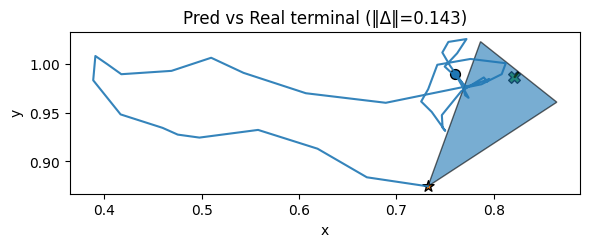

In [92]:
# 1) Execute the plan from the same s0 we planned with
# traj_xy = execute_skills(env, z_seq, s0_obs, horizon_per_skill=T, seed=123)

# 2) Compare predicted vs. realized terminal (x,y)
xy_pred = pred_xy                     # from the planner
xy_real = traj_xy[-1]                 # last point in the executed rollout
err = np.linalg.norm(xy_real - xy_pred)

print("Pred terminal xy:", xy_pred)
print("Real terminal xy:", xy_real)
print("L2 error:", float(err))

# 3) Quick plot: trajectory + both terminals
plt.figure(figsize=(6,5.5))
plt.plot(traj_xy[:,0], traj_xy[:,1], '-', lw=1.5, alpha=0.9, label="trajectory")
plt.scatter(traj_xy[0,0], traj_xy[0,1], s=50, marker='o', edgecolors='k', label='start')
plt.scatter(xy_real[0], xy_real[1], s=70, marker='*', edgecolors='k', label='real terminal')
plt.scatter(xy_pred[0], xy_pred[1], s=70, marker='X', edgecolors='k', label='pred terminal')

# arrow from pred -> real
plt.arrow(xy_pred[0], xy_pred[1],
          (xy_real[0]-xy_pred[0]), (xy_real[1]-xy_pred[1]),
          length_includes_head=True, head_width=0.1, alpha=0.6)

plt.gca().set_aspect('equal', 'box')
plt.xlabel("x"); plt.ylabel("y")
plt.title(f"Pred vs Real terminal (‖Δ‖={err:.3f})")
# plt.legend()
plt.tight_layout()
plt.show()


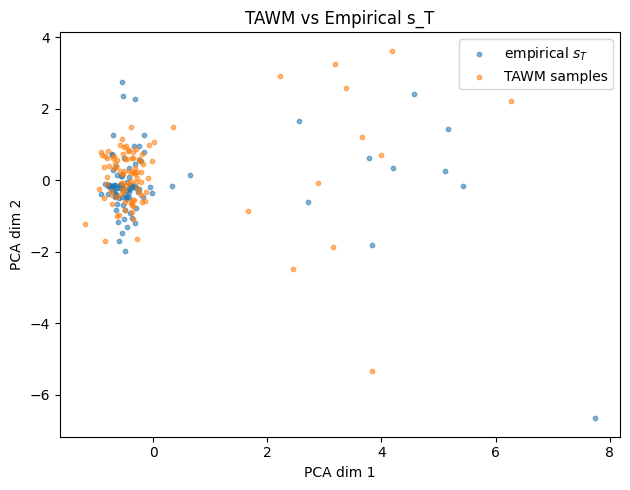

In [ ]:
@torch.no_grad()
def offline_compare_oneplot(
    batch, q_phi, p_psi, p_omega=None,
    use_posterior=True,
    title=""
):
    device = next(q_phi.parameters()).device
    # Unpack the validation batch
    s0  = batch["s0"].to(device)
    S   = batch["state_sequence"].to(device)
    A   = batch["action_sequence"].to(device)
    sT  = batch["sT"].to(device)
    B   = s0.size(0)

    # choose z a skill (either from the posterior or prior)
    if use_posterior:
        mu_z, std_z = q_phi(S, A)
        z = mu_z + std_z * torch.randn_like(mu_z)
    else:
        mu_pr, std_pr = p_omega(s0)
        z = mu_pr + std_pr * torch.randn_like(mu_pr)

    # predictive normal dist from TAWM for each (s0,z)
    mu_sp, std_sp = p_psi(s0, z)

    sT_model = mu_sp + std_sp * torch.randn_like(mu_sp)   

    # PCA(2D) 
    # Concatenates real and sampled terminal states, fits PCA, transforms both, and makes a scatter plot
    X = torch.cat([sT, sT_model], dim=0).cpu().numpy()    
    pca = PCA(n_components=2)
    X2 = pca.fit_transform(X)
    E2, P2 = X2[:B], X2[B:]


    # dont do PCA on this
    # just look at the xy position

    plt.figure(figsize=(6.4, 5.0))
    plt.scatter(E2[:,0], E2[:,1], s=10, alpha=0.55, label="empirical $s_T$")
    plt.scatter(P2[:,0], P2[:,1], s=10, alpha=0.55, label="TAWM samples")
    plt.title(title)
    plt.xlabel("PCA dim 1"); plt.ylabel("PCA dim 2")
    plt.legend(); plt.tight_layout()
    plt.show()

batch = next(iter(val_loader))
offline_compare_oneplot(batch, q_phi, p_psi, p_omega=None, use_posterior=True, title="TAWM vs Empirical s_T for Validation")




In [48]:
data = b'\xAD\xDE\xDE\xC0'
my_data = bytearray(data)
print(my_data)
my_data.reverse()
print(my_data)

bytearray(b'\xad\xde\xde\xc0')
bytearray(b'\xc0\xde\xde\xad')


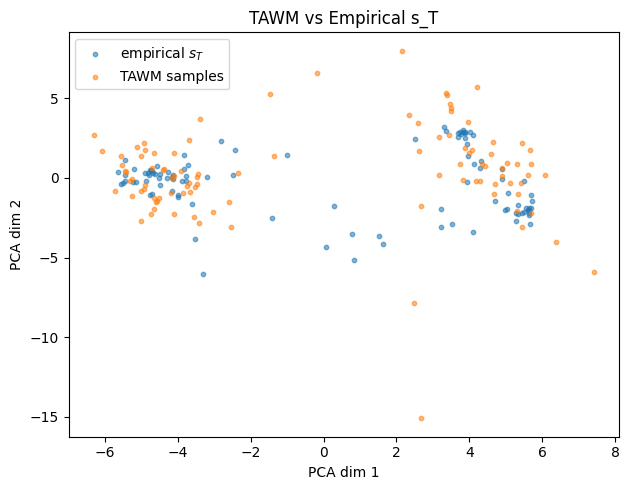

In [ ]:
batch = next(iter(test_loader))
offline_compare_oneplot(batch, q_phi, p_psi, p_omega=None, use_posterior=True, title="TAWM vs Empirical s_T for Test")

Saved skill_samples.png


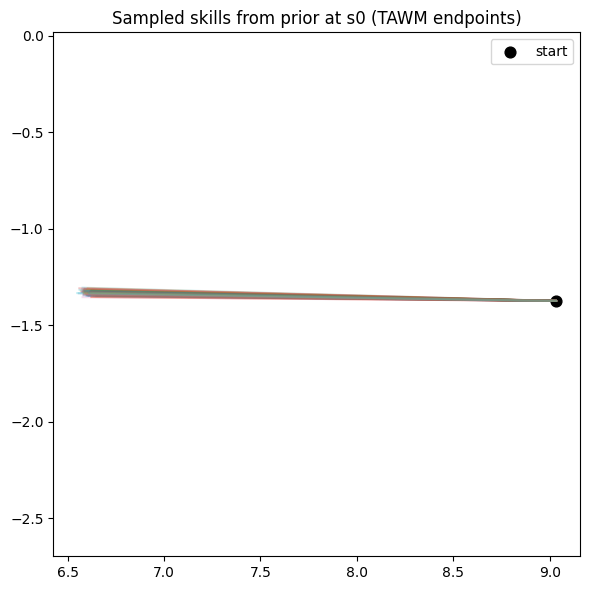

In [15]:
@torch.no_grad()
def visualize_skills(p_omega, p_psi, s0_full, K=100):
    """
    Takes as input a start state, s0.
    Then, samples K skills randomly from the skill prior.
    Finally, uses the TAWM to predict the terminal state of each skill.

    Plots s0->sT_pred as vectors using the x-y coordinates.
    """
    s0_full = torch.as_tensor(s0_full, dtype=torch.float32)
    s0_b = s0_full.unsqueeze(0) # ensure [1, state_dim]

    mu_z, std_z = p_omega(s0_b) # compute the metrics for a sampled skill                            
    Z = mu_z.shape[-1]

    # Sample K epsilons and map to skills using reparameterization trick
    eps = torch.randn(K, Z)                  
    z = mu_z + std_z * eps                                  

    s0_expanded = s0_b.expand(K, -1) 
    # Preduct the terminal state using sampled skills and start state                      
    sT_mu, _ = p_psi(s0_expanded, z)                        

    xy0 = s0_b[..., -2:]                                      
    xyT = sT_mu[..., -2:]                                     

    x0, y0 = xy0[0].tolist()

    plt.figure(figsize=(6,6))
    for i in range(K):
        plt.plot([x0, xyT[i,0].item()], [y0, xyT[i,1].item()], alpha=0.25)

    plt.scatter([x0], [y0], c="k", s=60, label="start")
    plt.axis("equal")
    plt.legend()
    plt.title("Sampled skills from prior at s0 (TAWM endpoints)")
    plt.tight_layout()
    plt.savefig("skill_samples.png", dpi=150)
    print("Saved skill_samples.png")


s0_env, _ = env.reset(seed=0)                              
obs = torch.tensor(s0_env["observation"], dtype=torch.float32)
ach = torch.tensor(s0_env["achieved_goal"], dtype=torch.float32)

s0_full = torch.cat([obs, ach], dim=-1)                   
visualize_skills(p_omega, p_psi, s0_full, K=100)


plot the actual temrinal state from t he skill and variance

In [41]:
# CEM Planner Parameters
H = 40
K = 1000 # batch size at each iteration of planning
L = 3 # length of sequence of epsilons in the batch
N_keep = 200 # number of sequences of skills to keep
N_iters = 10 # number of iterations to update the diagonal gaussian
tau = 30 # number of timesteps before replanning

In [21]:
LOG2PI = math.log(2 * math.pi)

@torch.no_grad()
def diag_gaussian_log_p(x, mu, std):
    # Computes the log p(x) of a diagonal gaussian
    var = std * std
    return (-0.5 * ((x - mu)**2 / var + 2.0 * std.log() + LOG2PI)).sum(dim=-1)

class CEMPlanner:
    def __init__(self, pi_theta, p_psi, p_omega, z_dim=Z_DIM, plan_len=L,
                 batch_size=K, n_keep=N_keep, iters=N_iters):
        self.pi_theta = pi_theta.eval()
        self.p_psi = p_psi.eval()
        self.p_omega = p_omega.eval()
        self.z_dim = z_dim
        self.L = plan_len
        self.batch_size = batch_size
        self.k = n_keep
        self.iters = iters
        # Keep track of the current mean and std of the diagonal Gaussian
        self.eps_mean = torch.zeros(self.L, z_dim)
        self.eps_std  = torch.ones (self.L, z_dim)

    @torch.no_grad()
    def _eps_to_z_seq(self, s0, eps_seq):
        """
        Given a eps_seq, convert each epsilon into a skill using the skill prior and use the TAWM to predict the state after the skill
        Output: returns the sequence of skills and the final predicted state
        """
        s = s0 # [1, state_dim]
        z_seq = []
        for t in range(self.L):
            mu_w, std_w = self.p_omega(s)               
            z_t = mu_w + std_w * eps_seq[t:t+1, :] # convert the et to zt 
            z_seq.append(z_t)
            # roll abstract world model to get next state (use mean for planning)
            mu_T, _ = self.p_psi(s, z_t)                
            s = mu_T
        z_seq = torch.cat(z_seq, dim=0)                 
        return z_seq, s # final predicted state after L skills

    @torch.no_grad()
    def _cost_fn(self, s0, goal_xy, eps_batch):
        """
        Computes the cost of each sequence of skills in the batch
        """
        # eps_batch: [K, L]
        N = eps_batch.shape[0]
        costs = torch.empty(N)
        # For each batch, find the final predicted state and extract the xy coordinates from the state. Then, compute the l2 distance
        for i in range(N):
            _, sT = self._eps_to_z_seq(s0, eps_batch[i])    
            sT_xy = sT[..., -2:]                 
            costs[i] = torch.linalg.norm(sT_xy[0] - goal_xy[0], ord=2)
        return costs

    @torch.no_grad()
    def plan(self, s0, goal):
        """
        Given a start state, fit a diagonal Gaussian using the N_keep best costs for N_iters
        """
        mean = self.eps_mean.clone()
        std  = self.eps_std.clone()

        for _ in range(self.iters):
            eps = mean + std * torch.randn(self.batch_size, self.L, self.z_dim) # sample K L-length sequences of epsilons from a unit Gaussian
            costs = self._cost_fn(s0, goal, eps) # compute the costs of each sequence
            top_k = torch.topk(-costs, self.k).indices # extract the indices of the N_keep best
            top_k_eps = eps[top_k]                           
            mean = top_k_eps.mean(dim=0) # take the mean and std of the epsilon sequences across the N_keep best sequences
            std  = top_k_eps.std(dim=0) + 1e-6

        final_eps = mean + std * torch.randn(self.batch_size, self.L, self.z_dim)
        final_costs = self._cost_fn(s0, goal, final_eps)
        best_idx = torch.argmin(final_costs)
        best_eps = final_eps[best_idx]

        self.eps_mean = torch.zeros_like(self.eps_mean)
        self.eps_std  = torch.ones_like(self.eps_std)

        # find the sequence of skills in the best sequence
        z_seq, _ = self._eps_to_z_seq(s0, best_eps)
        return z_seq[0:1, :], mean, std # z_seq[0:1, :]: [1, z_dim] returns the first skill in the best sequence



In [22]:
def combine_state(obs, device):
    base = np.asarray(obs["observation"], dtype=np.float32)   
    ach = np.asarray(obs["achieved_goal"], dtype=np.float32)      
    s = np.concatenate([base, ach], axis=-1)                
    return torch.as_tensor(s, dtype=torch.float32, device=device).unsqueeze(0)  

def get_goal_xy(obs, device):
    assert isinstance(obs, dict)
    g = np.asarray(obs["desired_goal"], dtype=np.float32)         
    return torch.as_tensor(g, dtype=torch.float32, device=device).unsqueeze(0)  


planner = CEMPlanner(
    pi_theta, p_psi, p_omega,
    z_dim=Z_DIM, plan_len=L,
    batch_size=K, n_keep=N_keep, iters=N_iters 
)

max_steps = 2000
obs = env.reset(seed=0)[0]

state   = combine_state(obs, device)      
goal_xy = get_goal_xy(obs, device) 

steps = 0
while steps < max_steps:
    z_1, eps_mean, eps_std = planner.plan(state, goal_xy) # z_1: [1, Z_DIM]

    # Execute this skill for τ low-level steps, then replan
    for _ in range(tau):
        with torch.no_grad():
            mu_a, _ = pi_theta(state, z_1) # [1, a_dim]
            a = mu_a.squeeze(0).cpu().numpy().astype(np.float32)

        next_obs, reward, terminated, truncated, info = env.step(a)
        print("action norm =", np.linalg.norm(a))
        done  = terminated or truncated
        state = combine_state(next_obs, device) # rebuild [1,29] by adding in the xy location
        steps += 1

        # Distance check using last two dims of the concatenated state
        curr_xy = state[..., -2:][0]      
        if torch.linalg.vector_norm(curr_xy - goal_xy[0]) < 1.0 or done:
            break
    curr_xy = state[..., -2:][0]
    print(f"Current location {curr_xy}")
    dist_from_goal = torch.linalg.vector_norm(curr_xy - goal_xy[0])
    print(f"Current distance from goal: {dist_from_goal}")
    if torch.linalg.vector_norm(curr_xy - goal_xy[0]) < 1.0 or done:
        break


action norm = 8.650285
action norm = 8.304071
action norm = 8.338103
action norm = 6.7899942
action norm = 9.679301
action norm = 8.280436
action norm = 9.022188
action norm = 8.296698
action norm = 8.115069
action norm = 8.101042
action norm = 8.100147
action norm = 8.100793
action norm = 8.101016
action norm = 8.1010475
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
action norm = 8.101049
Current location tensor([ 9.0616, -1.4120])
Current distance from goal: 18.201610565185547
action norm = 8.030553
action norm = 8.030803
action norm = 8.03063
action norm = 8.030596
action norm = 8.030591
action norm = 8.030591
action norm = 8.03059
action norm = 8.03059
action norm = 8.03059
action norm = 

KeyboardInterrupt: 

In [44]:
S_mean_t = torch.as_tensor(S_mean, dtype=torch.float32, device=device)
S_std_t  = torch.as_tensor(S_std,  dtype=torch.float32, device=device)

def to_model_state(obs_dict):
    """turns env obs to concat state that is normalized for model"""
    s = combine_state(obs_dict, device=device)           
    s_norm = (s - S_mean_t.unsqueeze(0)) / S_std_t.unsqueeze(0)
    return s, s_norm                                     

def model_to_env_action(mu_a, deterministic=True):
    """squashes action in [-1,1]"""
    if deterministic:
        a_pre = mu_a                                      
    a = torch.tanh(a_pre) # squash to [-1,1]
    return a.squeeze(0).cpu().numpy().astype(np.float32)

planner = CEMPlanner(
    pi_theta, p_psi, p_omega,
    z_dim=Z_DIM, plan_len=L,
    batch_size=K, n_keep=N_keep, iters=N_iters,
)

max_steps = 10000

obs, _info = env.reset(seed=0)
state_env, state_norm = to_model_state(obs)               
goal_xy = get_goal_xy(obs, device)                      

steps = 0
while steps < max_steps:
    # CEM should plan in model space (normalized state)
    z_1, eps_mean, eps_std = planner.plan(state_norm, goal_xy)  

    # Execute this skill for tau low-level steps, then replan
    for _ in range(tau):
        with torch.no_grad():
            mu_a, _ = pi_theta(state_norm, z_1) # pre-squash params
            a = model_to_env_action(mu_a, deterministic=True)

        next_obs, reward, terminated, truncated, info = env.step(a)

        # update states
        state_env, state_norm = to_model_state(next_obs)

        steps += 1

        curr_xy = state_env[..., -2:][0]
        dist_from_goal = torch.linalg.vector_norm(curr_xy - goal_xy[0])
        print(f"Current location {curr_xy} | dist - {dist_from_goal:.3f} | action - {np.linalg.norm(a):.3f}")

        if dist_from_goal < 1.0 or terminated or truncated:
            break

    if dist_from_goal < 1.0 or terminated or truncated:
        break


Current location tensor([ 9.0522, -1.3759]) | dist - 18.213 | action - 2.591
Current location tensor([ 9.0969, -1.3799]) | dist - 18.248 | action - 2.613
Current location tensor([ 9.1016, -1.3734]) | dist - 18.256 | action - 2.717
Current location tensor([ 9.0972, -1.3734]) | dist - 18.252 | action - 2.566
Current location tensor([ 9.0863, -1.3738]) | dist - 18.243 | action - 2.160
Current location tensor([ 9.0504, -1.3806]) | dist - 18.208 | action - 2.240
Current location tensor([ 8.9713, -1.3963]) | dist - 18.133 | action - 1.910
Current location tensor([ 8.9093, -1.3941]) | dist - 18.081 | action - 2.441
Current location tensor([ 8.8666, -1.3918]) | dist - 18.046 | action - 2.577
Current location tensor([ 8.8566, -1.4065]) | dist - 18.030 | action - 2.500
Current location tensor([ 8.8162, -1.4176]) | dist - 17.990 | action - 2.575
Current location tensor([ 8.7073, -1.4329]) | dist - 17.889 | action - 2.341
Current location tensor([ 8.5710, -1.4255]) | dist - 17.778 | action - 2.119

initialize ants in some location
- sample skill, and run that skill many times and reset ant state after each run of the skill
- compare distribution of states that you end up to the predicted distribution by the TAWM

split into train/test/val by holding out entire trajectories
then plot val and train loss (should plateau and then rise)

- might not need to run E-M like paper
- state decoder and action decoder take z as input, but dont want to backprop gradietns from state decoder to encoder
- can simply detach the gradients

# try this out instead of E-M
z_mean,z_std = encoder(traj)
z ~ N(z_mean,z_std)
z_detached = z.detach()
a_mean,a_std = action_decoder(states,z)
s_mean,s_std = state_decoder(s0,z_detached)

do dir. env.env.env to get down to mujoco environments which allows you to reset more of the variables like 
set qval and set qpol